# Part 1: Datasets and Assets
<br>

<div align="center">
    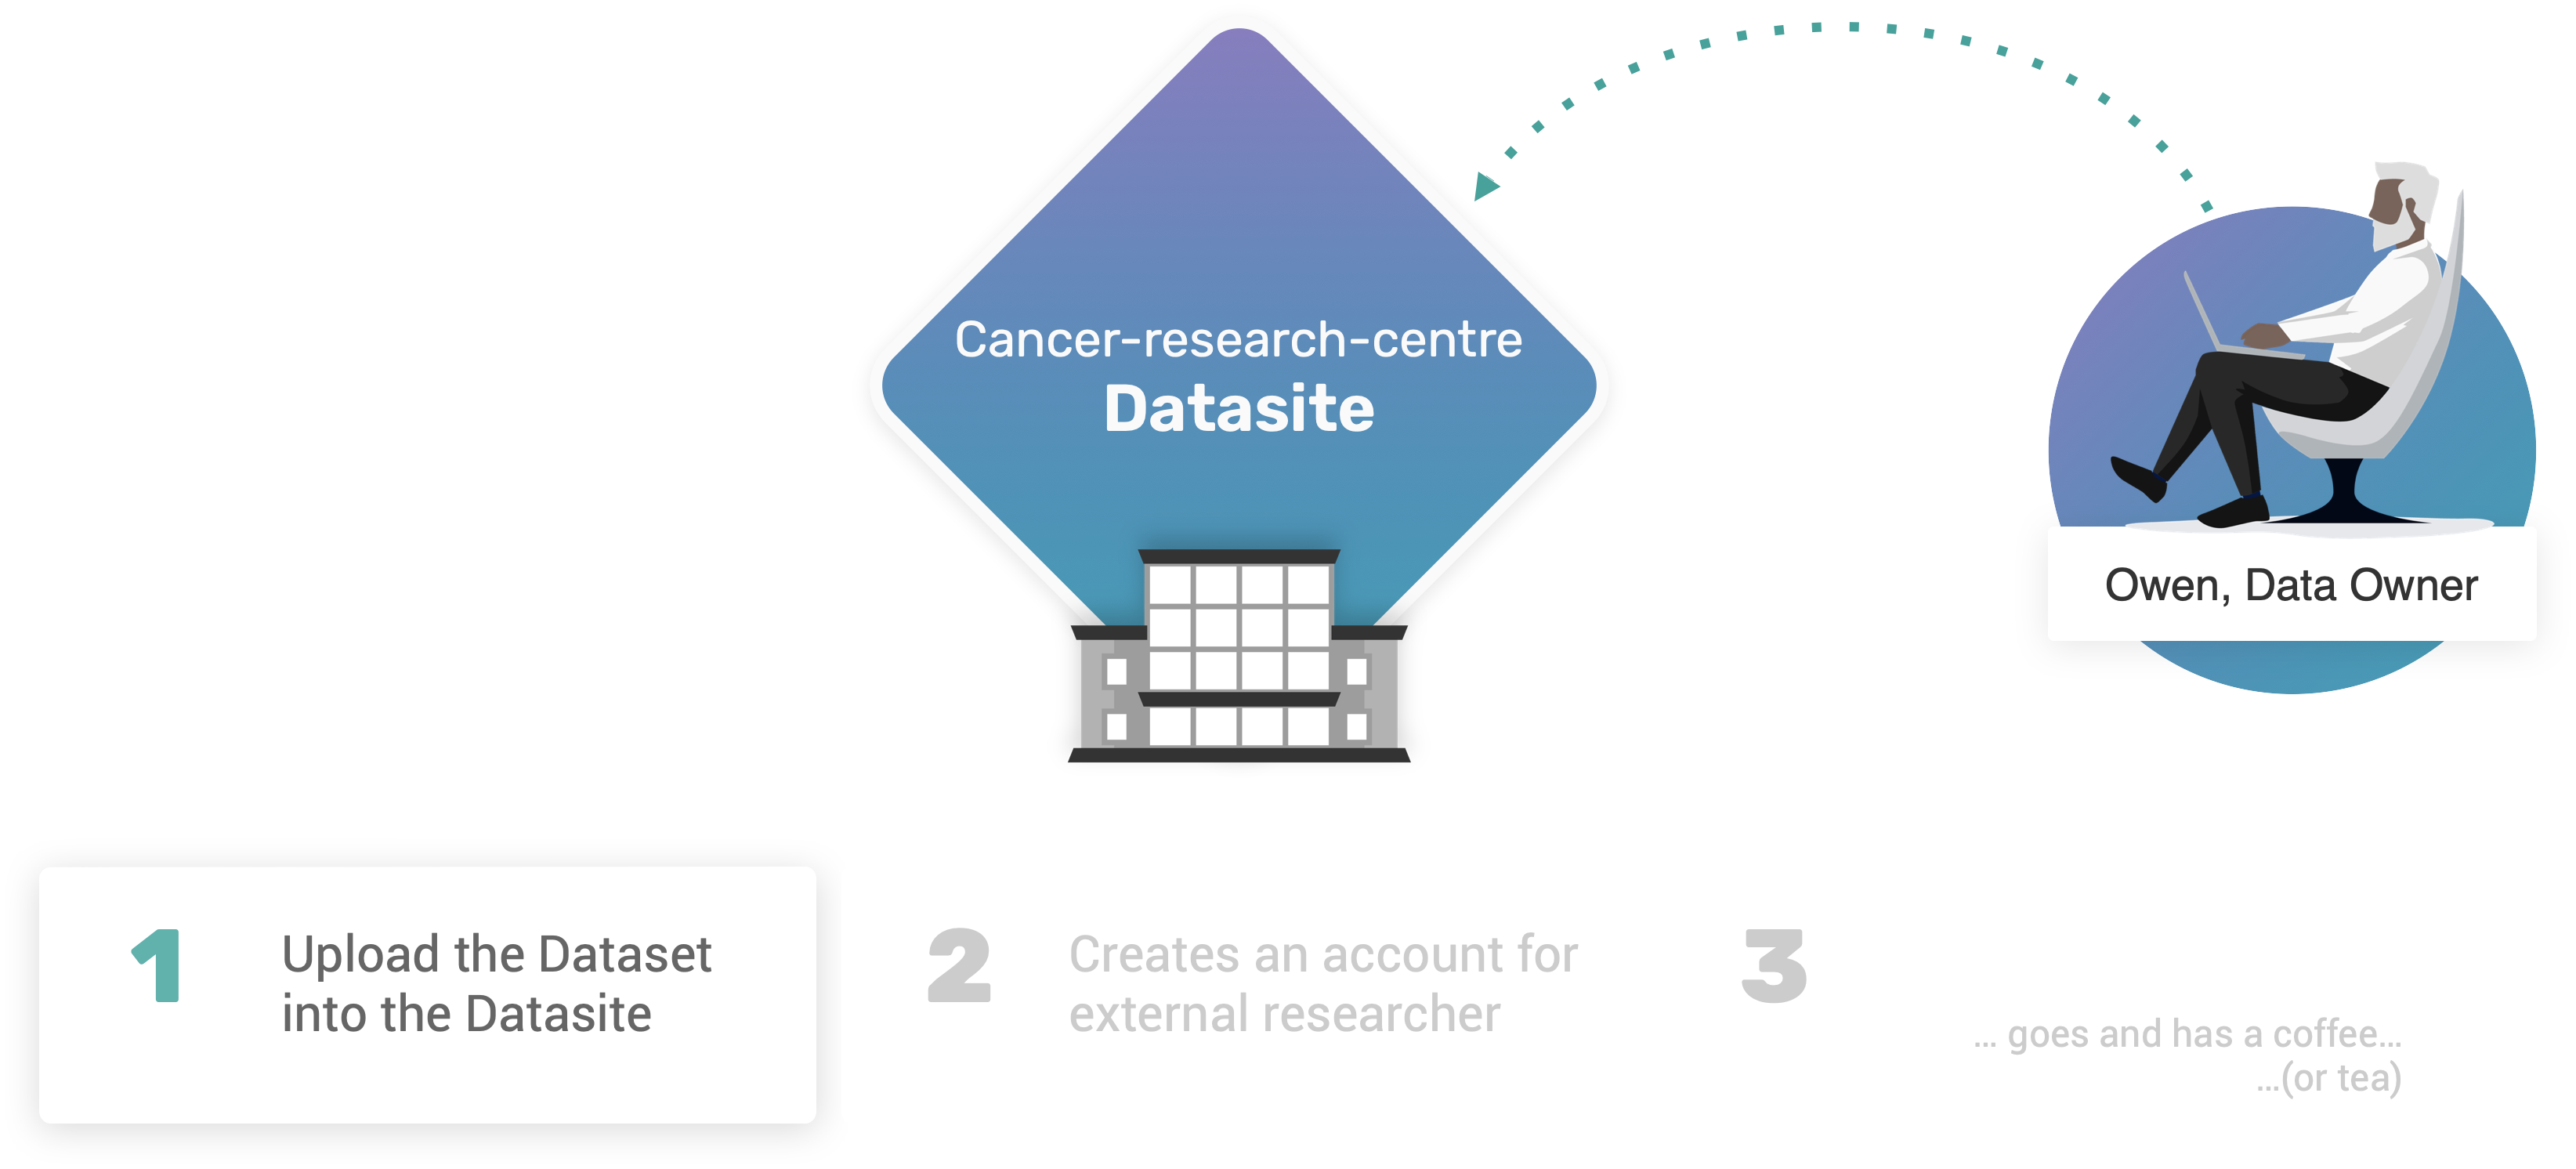
</div>

<br>

If you are new to PySyft, you need to know one word: [**Datasite**](../components/datasite-server.ipynb). A Datasite is like a website, but for data instead. Web servers let you download files (e.g. `.html`, `.css`) to your browser. Datasites don't. Instead, a Datasite helps a data scientist to download **the answer to a question** from data in the server, **without downloading the data itself**. Data in a Datasite are made available as _datasets_, each containing multiple assets. 
In this first the tutorial, we will learn how create and upload assets and datasets to a Datasite.

<br>

<div align="center">
    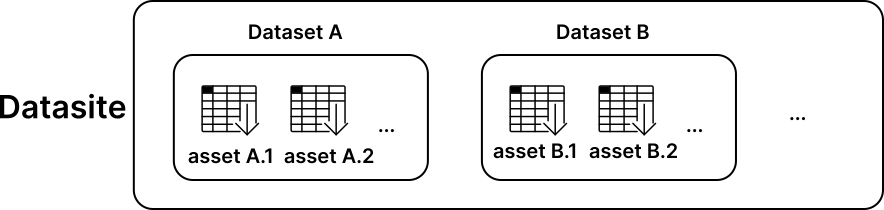
</div>

## What you will learn:

By the end of **part 1**, you will learn:

- How to quickly launch a local Datasite using PySyft;
- How to create and configre assets holding public, and non-public information;
- How to upload a dataset to a Datasite.

## |:data_scientist:| 1.1. Launch a local development Datasite

You can launch a Datasite server in three ways: 
1. using [`syft.orchestra.launch`](../deployment/deployment-doc-3-local-dev.ipynb): good for local development;
2. using [a single container (Docker, Podman)](../deployment/deployment-doc-4-0-container-based-deployment.ipynb): good for lightweight deployments;
3. using [Kubernetes](../deployment/deployment-doc-5-0-deploy-k8s.ipynb): good for production environments;

In this introductory tutorial, we are going to use `syft.orchestra.launch`. Please learn more about the [Datasite](../components/datasite-server.ipynb) and [deployment](../deployment/deployment-doc-1-2-intro-req.ipynb) options in the corresponding sections of the documentation.

Let's first import `syft` as `sy` (_we will use this coding convention throughout the tutorial_, ed.):

In [ ]:
import syft as sy

The `syft.orchestra.launch` functions runs a special [local Datasite server](../deployment/deployment-doc-3-local-dev.ipynb), that is only intended for development purposes. Each server is identified by its unique `name`, which is used by PySyft to restore its internal state in case of rebooting. We will use the `reset=True` option to make sure that the server instance will be initialised for the first time.

In [ ]:
data_site = sy.orchestra.launch(name="cancer-research-centre", reset=True)

Once the server is up and running, we can login into the Datasite:

In [ ]:
client = data_site.login(email="info@openmined.org", password="changethis")

```{admonition} Managing user accounts
As initial first step, Owen will use the <em>default</em> admin credentials to login to the Datasite. In [Part 2: Datasite Access](./part2-datasite-access.ipynb), we will learn how to update and personalise these credentials, as well as how to manage user accounts.
```

## |:data_scientist:| 1.2. Downloading our example dataset

To download our example dataset, we will use the `ucimlrepo` Python package, that can be installed using `pip`:

```bash
$ pip install ucimlrepo
```

```{admonition} Use the correct Python environment
:class: tip
Please make sure to install this package in the same Python environment where also PySyft is installed. See the [Quick Install](../quick-install.ipynb) guide for further instructions.
```

When it is done, let's use the following code to download the [dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic):

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata 
metadata = breast_cancer_wisconsin_diagnostic.metadata
# variable information 
variables = breast_cancer_wisconsin_diagnostic.variables

We will use the popular [**Breast Cancer Dataset**](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) to simulate a version of the Owen's "Breast Cancer Biomarker" dataset.

In [ ]:
X.head(n=5)  # n specifies how many rows we want in the preview

This dataset contains `596` samples, organised in `30` clinical features (i.e. `X`). 

In [ ]:
X.shape

Each sample corresponds to a single _categorical_ target, identifying the outcome of the tumour: `B` as in _Bening_; and `M` as in _Malign_:

In [ ]:
y.sample(n=5, random_state=10)

## |:data_scientist:| 1.3. Create Assets and Dataset

In the very beginning of this tutorial, I introduced PySyft by saying that it allows to work with data **without downloading nor seeing** any copy of the data itself. At this point though, you may be wondering:

```{epigraph}
1. How would it be possible for a data scientist to write their code against data they don't have?

2. How would they even know where to begin? 🤔
```
PySyft will solve this problem by hosting **two kinds** of data. First, it will host the _real_ data (more on that in a minute); second, it will host _mock_ data, that is a fake version of the real data that data scientists can download and see. 

### Create Mock Data

So, before we upload our dataset to the Datasite, Owen needs to create a _mock_ version of their data. Let's do that now!

In [ ]:
import numpy as np

# fix seed for reproducibility
SEED = 12345
np.random.seed(SEED)

X_mock = X.apply(lambda s: s + np.mean(s) + np.random.uniform(size=len(s)))
y_mock = y.sample(frac=1, random_state=SEED).reset_index(drop=True)

The clinical features `X_mock` are obtained from the original `X` by adding the _arithmetic mean_ of each corresponding column, plus some random noise from a normal distribution. The categorical targets `y_mock` are created by simply shuffling their original values. In this way, the data types as well as the _class distribution_ remains unchanged, whilst any possible pattern with the samples is dropped. 

```{admonition} Generating mock data
Determining what would be a **good** or **bad** mock data solution varies according to the specific use case, and dataset. Ultimately it is a responsibility of the Data Owner to decide what solution to choose that would better fit in the desired data usage. 

In our example, it was Owen's decision to establish that the technique we have used to create the mock data was good enough to not leak any private information from the **real** data.
```

### Create [Assets](../components/datasets.ipynb#create-an-asset)

Now that we have both _real_ and _mock_ data, we are ready to create the corresponding assets in PySyft, each identified by their unique `name` within the Datasite.

In [ ]:
features_asset = sy.Asset(
    name="Breast Cancer Data: Features",
    data = X,      # real data
    mock = X_mock  # mock data
)

targets_asset = sy.Asset(
    name="Breast Cancer Data: Targets",
    data = y,      # real data
    mock = y_mock  # mock data
)

Please notice how each asset holds a reference to `data` and `mock`, which are also two properties of a `syft.Asset` object that we can inspect: 

In [ ]:
features_asset.data.head(n=3)

In [ ]:
features_asset.mock.head(n=3)

### Create a [Dataset](../components/datasets.ipynb#create-a-dataset)

Ok, so we have got two assets: `features_asset`, and `targets_asset`, and now we're ready to upload them to the Datasite server $\ldots$ _right_ ?! Well, not quite! There's a problem:

```{epigraph}
If we were to upload these assets as-is to our Datasite with no additional information, how could an external data scientist ever find and know how to use the data?
```

For this reason, PySyft expects each asset to be stored as part of a `syft.Dataset` object. Each dataset in PySyft is identified by its _unique_ name, and contains additional metadata (e.g. `description`, `citation`, `contributors`) that further describe the _core_ data it includes in its assets.

Let's now collect our metadata, and then use it to create our `Dataset` object:

In [ ]:
# Metadata
description = f'{metadata["abstract"]}\n{metadata["additional_info"]["summary"]}'

paper = metadata["intro_paper"]
citation = f'{paper["authors"]} - {paper["title"]}, {paper["published_in"]}, {paper["year"]}'

summary = "The Breast Cancer Wisconsin dataset can be used to predict whether the cancer is benign or malignant."

# Dataset creation
breast_cancer_dataset = sy.Dataset(
    name="Breast Cancer Biomarker",
    description=description,
    summary=summary,
    citation=citation,
    url=metadata["dataset_doi"],
)

Finally, we can add the two assets to the dataset:

In [ ]:
breast_cancer_dataset.add_asset(features_asset)

breast_cancer_dataset.add_asset(targets_asset)

Let's finally have a look at the newly created `breast_cancer_dataset` object, using the default _rich_ representation offered by PySyft:

In [ ]:
breast_cancer_dataset

## |:data_scientist:|  1.4. Upload the Dataset to the Datasite

To upload a new dataset to the Datasite, we can call the `upload_dataset` function from the available `client`:

In [ ]:
client.upload_dataset(dataset=breast_cancer_dataset)

Well done! 👏 

The dataset has finally reached the Datasite 🎉. 

To verify that, we could explore all the `datasets` accessible through our `client` object:

In [ ]:
client.datasets

## |:data_scientist:| 1.5. Shutting down the Datasite

Once we are done with the upload of the dataset, we can shutdown the running server using the `land` function

In [ ]:
data_site.land()

## Congrats on completing Part 1 🎉

Well done for completing **part 1** of the tutorial! 👏 

In this part, we have learnt how to set up a Datasite for our "Cancer Research Centre". For simplicity, and with no loss of generality, we have used the _local development server_ included in PySyft to quickly host a Datasite server on our local machine. We have then created and uploaded a new `syft.Dataset` to the Datasite, including assets for _features_ and _targets_ for the "Breast Cancer Biomarker" data.

In [**part 2**](./part2-datasite-access.ipynb) we will learn how to manage user credentials, and set up access to a Datasite.